# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [1]:
import numpy as np
import copy
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn

np.random.seed(42)

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [2]:
class Module:
    """
    Абстрактный класс.
    """

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, d):
        raise NotImplementedError()

    def update(self, alpha):
        pass


In [3]:

class Linear(Module):
    """
    Линейный полносвязный слой.
    """

    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int
            Размер выхода.

        Notes
        -----
        W и b инициализируются случайно.
        """
        std = in_features ** 0.5
        self.W = np.random.randn(out_features, in_features) / std
        self.b = np.random.randn(out_features)
        self.input = None
        self.W_grad = None
        self.b_grad = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Wx + b.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).

        Return
        ------
        y : np.ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        self.input = copy.deepcopy(x)
        return np.array(x).dot(self.W.T) + self.b

    def backward(self, d: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        self.W_grad = np.array([np.outer(a, b) for a, b in zip(self.input, d)])
        self.b_grad = copy.deepcopy(d)
        return d.dot(self.W)

    def update(self, alpha: float) -> NoReturn:
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """
        delta = self.W_grad.mean(axis=0) * alpha
        self.W += delta.T
        delta = self.b_grad.mean(axis=0) * alpha
        self.b += delta.T

In [4]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """

    def __init__(self):
        self.input = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.

        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self.input = copy.deepcopy(x)
        return np.maximum(0, self.input)

    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        mask = self.input.reshape(-1) > 0
        grad = np.zeros(d.shape)
        grad.reshape(-1)[mask] = d.reshape(-1)[mask]
        return grad


class Softmax(Module):
    """
    Слой, соответствующий функции активации Softmax.
    """

    def __init__(self):
        self.activation = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Softmax(x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.

        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        x_exp_normalized = np.exp(x - np.max(x))
        self.activation = x_exp_normalized / np.sum(x_exp_normalized, axis=-1, keepdims=True)
        return self.activation

    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        return d * self.activation * (1 - self.activation)

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [5]:
class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : List[Module]
            Список, состоящий из ранее реализованных модулей и
            описывающий слои нейронной сети.
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обучения
        alpha : float
            Скорость обучения.
        """
        self.modules = modules + [Softmax()]
        self.epochs = epochs
        self.alpha = alpha

    def fit(self, X: np.ndarray, y: np.ndarray, batch_size=32) -> NoReturn:
        """
        Обучает нейронную сеть заданное число эпох.
        В каждой эпохе необходимо использовать cross-entropy loss для обучения,
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """
        n_steps = int(np.ceil(len(X) / batch_size))
        classes = np.unique(y)
        y = np.array([[int(yy == c) for c in classes]
                      for yy in y])

        for _ in range(self.epochs):
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y[indices]
            for i in range(n_steps):
                l, r = i * batch_size, min((i + 1) * batch_size, len(X_shuffled))
                X_batch, y_batch = X_shuffled[l:r], y_shuffled[l:r]
                for m in self.modules:
                    X_batch = m.forward(X_batch)
                d = y_batch / X_batch
                for m in reversed(self.modules):
                    d = m.backward(d)
                for m in self.modules:
                    m.update(self.alpha)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.

        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)

        """
        for m in self.modules:
            X = m.forward(X)
        return X

    def predict(self, X) -> np.ndarray:
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.

        Return
        ------
        np.ndarray
            Вектор предсказанных классов

        """
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [6]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = np.array([(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X])
p.fit(X, y, batch_size=32)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [7]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p = MLPClassifier([
                       Linear(2, 16),
                       ReLU(),
                       Linear(16, 16),
                       ReLU(),
                       Linear(16, 2),
                       ],
                      alpha=0.002)

    p.fit(X, y, batch_size=32)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.885


In [8]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier([
                       Linear(2, 16),
                       ReLU(),
                       Linear(16, 16),
                       ReLU(),
                       Linear(16, 3),
                       ], 
                       alpha=0.002)
    p.fit(X, y,  batch_size=32)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.9525


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self._layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1), 
            nn.ReLU(),

            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride=2), 
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(800, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._layers(x)
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    preds = model(X)
    return F.cross_entropy(preds, y)

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [12]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in tqdm(range(1, epochs + 1)):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [13]:
model = Model().to(device)
train_l, test_l = train(model, epochs=40)

  2%|▎         | 1/40 [00:37<24:05, 37.05s/it]

Epoch 1 | Train loss 2.0387307322311403 | Test loss 1.848647530555725


  5%|▌         | 2/40 [01:13<23:20, 36.84s/it]

Epoch 2 | Train loss 1.7663790322494506 | Test loss 1.6782336778640747


  8%|▊         | 3/40 [01:51<23:02, 37.37s/it]

Epoch 3 | Train loss 1.6577338019180299 | Test loss 1.6034801496505737


 10%|█         | 4/40 [02:28<22:18, 37.19s/it]

Epoch 4 | Train loss 1.5920847072219848 | Test loss 1.5551266328811646


 12%|█▎        | 5/40 [03:05<21:38, 37.10s/it]

Epoch 5 | Train loss 1.550633854408264 | Test loss 1.5345998640060425


 15%|█▌        | 6/40 [03:42<20:57, 37.00s/it]

Epoch 6 | Train loss 1.4923401596069337 | Test loss 1.480566697883606


 18%|█▊        | 7/40 [04:19<20:21, 37.02s/it]

Epoch 7 | Train loss 1.4569531615066529 | Test loss 1.4597939905166626


 20%|██        | 8/40 [04:56<19:47, 37.12s/it]

Epoch 8 | Train loss 1.423763810081482 | Test loss 1.4276972282409668


 22%|██▎       | 9/40 [05:34<19:12, 37.19s/it]

Epoch 9 | Train loss 1.3952356734848022 | Test loss 1.4007784023284913


 25%|██▌       | 10/40 [06:10<18:32, 37.08s/it]

Epoch 10 | Train loss 1.3670640897750854 | Test loss 1.3840372968673706


 28%|██▊       | 11/40 [06:47<17:53, 37.01s/it]

Epoch 11 | Train loss 1.3364675966644286 | Test loss 1.338543501663208


 30%|███       | 12/40 [07:24<17:15, 36.99s/it]

Epoch 12 | Train loss 1.309109283065796 | Test loss 1.3244517948150634


 32%|███▎      | 13/40 [08:01<16:37, 36.95s/it]

Epoch 13 | Train loss 1.2977857913970947 | Test loss 1.350508225440979


 35%|███▌      | 14/40 [08:38<16:01, 36.97s/it]

Epoch 14 | Train loss 1.268220912437439 | Test loss 1.2937687831878661


 38%|███▊      | 15/40 [09:15<15:24, 36.99s/it]

Epoch 15 | Train loss 1.253973945388794 | Test loss 1.3158726655960082


 40%|████      | 16/40 [09:54<15:00, 37.54s/it]

Epoch 16 | Train loss 1.2311580986404418 | Test loss 1.2685939353942872


 42%|████▎     | 17/40 [10:31<14:21, 37.47s/it]

Epoch 17 | Train loss 1.2268989865493773 | Test loss 1.274601349067688


 45%|████▌     | 18/40 [11:08<13:41, 37.35s/it]

Epoch 18 | Train loss 1.1892979219436646 | Test loss 1.2375548099517821


 48%|████▊     | 19/40 [11:45<13:02, 37.26s/it]

Epoch 19 | Train loss 1.1893861735153197 | Test loss 1.2363566387176514


 50%|█████     | 20/40 [12:22<12:23, 37.20s/it]

Epoch 20 | Train loss 1.1557021390533446 | Test loss 1.2341110359191894


 52%|█████▎    | 21/40 [12:59<11:45, 37.14s/it]

Epoch 21 | Train loss 1.1413165069198608 | Test loss 1.2173389230728149


 55%|█████▌    | 22/40 [13:36<11:07, 37.10s/it]

Epoch 22 | Train loss 1.1256624367523194 | Test loss 1.2064126092910767


 57%|█████▊    | 23/40 [14:14<10:30, 37.08s/it]

Epoch 23 | Train loss 1.1211447623825073 | Test loss 1.2081150901794433


 60%|██████    | 24/40 [14:50<09:52, 37.04s/it]

Epoch 24 | Train loss 1.0993610527801514 | Test loss 1.1963403400421142


 62%|██████▎   | 25/40 [15:28<09:16, 37.13s/it]

Epoch 25 | Train loss 1.0703229863357544 | Test loss 1.1905911115646362


 65%|██████▌   | 26/40 [16:05<08:40, 37.19s/it]

Epoch 26 | Train loss 1.0643982984924316 | Test loss 1.1805892906188964


 68%|██████▊   | 27/40 [16:42<08:04, 37.24s/it]

Epoch 27 | Train loss 1.0506810660552979 | Test loss 1.2158882144927978


 70%|███████   | 28/40 [17:20<07:27, 37.26s/it]

Epoch 28 | Train loss 1.0439652800369263 | Test loss 1.1627860929489136


 72%|███████▎  | 29/40 [17:57<06:50, 37.31s/it]

Epoch 29 | Train loss 1.0218621856689454 | Test loss 1.1628093618392945


 75%|███████▌  | 30/40 [18:35<06:13, 37.35s/it]

Epoch 30 | Train loss 1.0143832834243773 | Test loss 1.1507949089050293


 78%|███████▊  | 31/40 [19:12<05:36, 37.36s/it]

Epoch 31 | Train loss 0.9906645786476135 | Test loss 1.1431089763641358


 80%|████████  | 32/40 [19:49<04:58, 37.37s/it]

Epoch 32 | Train loss 0.980725334815979 | Test loss 1.1703273338317872


 82%|████████▎ | 33/40 [20:27<04:21, 37.34s/it]

Epoch 33 | Train loss 0.9613366938972473 | Test loss 1.1513035066604613


 85%|████████▌ | 34/40 [21:04<03:43, 37.24s/it]

Epoch 34 | Train loss 0.9493982503509522 | Test loss 1.1344126607894898


 88%|████████▊ | 35/40 [21:41<03:05, 37.15s/it]

Epoch 35 | Train loss 0.9442788737869263 | Test loss 1.1811286767959595


 90%|█████████ | 36/40 [22:18<02:28, 37.07s/it]

Epoch 36 | Train loss 0.9316654389953614 | Test loss 1.15242948513031


 92%|█████████▎| 37/40 [22:54<01:50, 36.90s/it]

Epoch 37 | Train loss 0.913840373840332 | Test loss 1.1346906316757202


 95%|█████████▌| 38/40 [23:31<01:13, 36.82s/it]

Epoch 38 | Train loss 0.8956435733795166 | Test loss 1.140757343673706


 98%|█████████▊| 39/40 [24:07<00:36, 36.78s/it]

Epoch 39 | Train loss 0.8877619599533081 | Test loss 1.1414508422851561


100%|██████████| 40/40 [24:44<00:00, 37.11s/it]

Epoch 40 | Train loss 0.868270841293335 | Test loss 1.1366325119018554


Построим график функции потерь

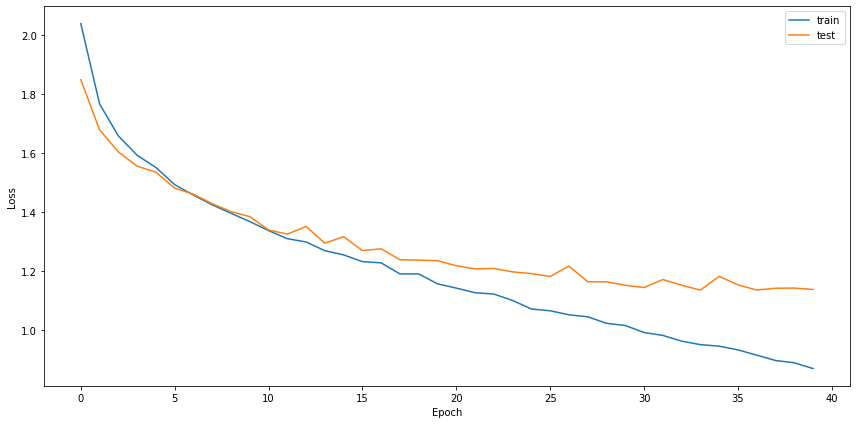

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [15]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.6082
Precision [0.63729128 0.70387454 0.52997275 0.44216867 0.54205607 0.50997151
 0.62489762 0.64874884 0.73513514 0.65246854]
Recall [0.687 0.763 0.389 0.367 0.522 0.537 0.763 0.7   0.68  0.674]
Mean Precision 0.6026584970164894
Mean Recall 0.6082000000000001
